# Titanic

In [251]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import torch
import torch.nn as nn
import torch.nn.functional as F

## Ⅰ 数据采集及存储

In [252]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [253]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Ⅱ 数据预处理
* 数据清洗
数据集成
数据变换
数据规约
* 数据缺失
重复
不同计量单位
噪声

### step1 数据清洗——处理缺失数据

In [254]:
train_data.isna().sum()
test_data['Fare'].isna()[417]

False

#### 为fare填充缺失值
* 由于fare是比较重要的特征，且与Ticket高度相关，因此采用KNN的方法用Ticket预测fare缺失值
  * fare中有一些0值，感觉不太合理，也进行替换
  * 考虑到Ticket中靠前的字符对票价影响大，故加入权重因子

In [255]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

def calculate_similarity(str1, str2):
    # 计算字符串相似度，加入权重因子
    weight = 1
    similarity = 0
    for i in range(min(len(str1), len(str2))):
        if str1[i] == str2[i]:
            similarity += weight
        weight *= 0.9  
    return similarity / max(len(str1), len(str2))

def fill_missing_values(data): # data是dataframe格式
    features = []
    targets = []
    max_len = 0

    encoder = LabelEncoder()

    data1 = data
    # 将非空和为0的样本作为训练数据
    for idx, sample in data1.iterrows():
        if not data1['Fare'].isna()[idx] == True and sample['Fare'] != 0:
            features.append(sample['Ticket'])
            targets.append(sample['Fare'])
            max_len = max(max_len, len(sample['Ticket']))
    
    print(len(features), len(targets))
    for i in range(len(features)):
        if(len(features[i]) < max_len):
            features[i] += ' ' * (max_len - len(features[i]))
        # 转化为label编码
        features[i] = encoder.fit_transform(list(features[i]))
        # label编码转化为数字
        feature_num = 0
        for element in features[i]:
            feature_num = feature_num * 10 + int(element)
        features[i] = feature_num

    features = np.array(features).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)
    print(features.shape, targets.shape)

    # 创建KNN回归模型
    knn = KNeighborsRegressor(n_neighbors=5, metric=calculate_similarity)
    knn.fit(features, targets)

    # 使用KNN模型预测缺失值
    for idx, sample in data.iterrows():
        if data1['Fare'].isna()[idx] == True or (sample['Fare'] == 0):
            print('begin')
            feature = sample['Ticket']
            # 补齐长度
            if(len(feature) < max_len):
                feature += ' ' * (max_len - len(feature))
            # 转化为label编码
            feature = encoder.fit_transform(list(feature))
            # label编码转化为数字
            feature_num = 0
            for element in feature:
                feature_num = feature_num * 10 + int(element)
            predicted_value = knn.predict(np.array(feature_num).reshape(-1, 1))
            data.loc[idx, 'Fare'] = predicted_value[0]
            print('Predicted value: ', predicted_value[0], ' for sample: ', idx)

    return data

In [256]:
#test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
train_data = fill_missing_values(train_data)

876 876
(876, 1) (876, 1)
begin
Predicted value:  [55.55]  for sample:  179
begin
Predicted value:  [55.55]  for sample:  263
begin
Predicted value:  [55.55]  for sample:  271
begin
Predicted value:  [55.55]  for sample:  277
begin
Predicted value:  [55.55]  for sample:  302
begin
Predicted value:  [55.55]  for sample:  413
begin
Predicted value:  [55.55]  for sample:  466
begin
Predicted value:  [55.55]  for sample:  481
begin
Predicted value:  [55.55]  for sample:  597
begin
Predicted value:  [55.55]  for sample:  633
begin
Predicted value:  [55.55]  for sample:  674
begin
Predicted value:  [55.55]  for sample:  732
begin
Predicted value:  [55.55]  for sample:  806
begin
Predicted value:  [55.55]  for sample:  815
begin
Predicted value:  [55.55]  for sample:  822


In [257]:
test_data = fill_missing_values(test_data)

415 415
(415, 1) (415, 1)
begin
Predicted value:  [30.3775]  for sample:  152
begin
Predicted value:  [30.3775]  for sample:  266
begin
Predicted value:  [30.3775]  for sample:  372


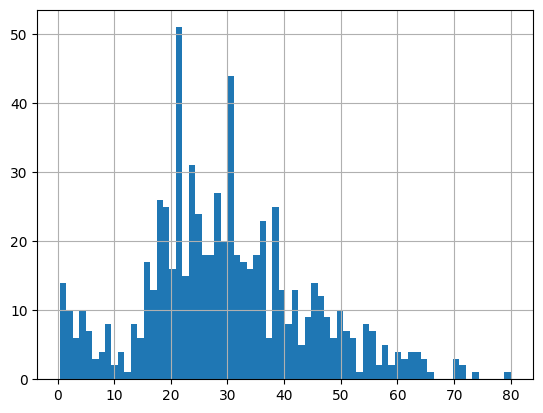

In [258]:
# 查看年龄分布
train_data['Age'].hist(bins=70)
# 选择用中位数填充年龄
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

In [259]:
# 查看embarked的取值分布
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [260]:
# 缺失embarked的数据较少（只有两条），用众数填充
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [261]:
# cabin数据缺失太多，先暂时不填充，待特征工程时再决定如何处理

### 数据清理——噪声处理
* 经检验，数据非常整齐，没有明显噪声

In [262]:
# 观察各特征值有无异常值
a = train_data['PassengerId'].nunique() == train_data.shape[0]
print(f'passengerId各不相同：{a}\n')
b = train_data['Survived'].value_counts()
print(f'Survived 可能的取值：\n{b}\n')
c = train_data['Pclass'].value_counts()
print(f'Pclass 可能的取值：\n{c}\n')
d = train_data["Name"].nunique() == train_data.shape[0]
print(f'Name各不相同：{d}\n')
e = train_data["Sex"].value_counts()
print(f'Sex 可能的取值：\n{e}\n')
f = train_data["Age"].min()
g = train_data["Age"].max()
print(f'Age 可能的取值范围：{f}~{g}\n')
h = train_data["SibSp"].value_counts()
print(f'SibSp 可能的取值：\n{h}\n')
i = train_data["Parch"].value_counts()
print(f'Parch 可能的取值：\n{i}\n')
j = train_data["Ticket"].value_counts()
print(f'Ticket 可能的取值：\n{j}\n')
k = train_data["Fare"].min()
l = train_data["Fare"].max()
print(f'Fare 可能的取值范围：{k}~{l}\n')
m = train_data["Cabin"].value_counts()
print(f'Cabin 可能的取值：\n{m}\n')
n = train_data["Embarked"].value_counts()
print(f'Embarked 可能的取值：\n{n}\n')

# 未发现数据中含有异常值：
# 年龄票价等连续值均大于0且取值符合常理
# 离散值类型一致，不存在数字和字符串混合的情况；id等唯一值各不相同


passengerId各不相同：True

Survived 可能的取值：
0    549
1    342
Name: Survived, dtype: int64

Pclass 可能的取值：
3    491
1    216
2    184
Name: Pclass, dtype: int64

Name各不相同：True

Sex 可能的取值：
male      577
female    314
Name: Sex, dtype: int64

Age 可能的取值范围：0.42~80.0

SibSp 可能的取值：
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Parch 可能的取值：
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Ticket 可能的取值：
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Fare 可能的取值范围：4.0125~512.3292

Cabin 可能的取值：
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Embarked 可能的取值：
S    646
C    168
Q     77
Name: Embarked,

### step2 数据集成
* 只有一个数据源，无需集成

### step3 数据变换
* 规范化、离散化

In [263]:
# 决策树、随机森林对数据的原始尺度不敏感，可能不需要归一化、离散化
# SVM、KNN、xgboost等模型对数据的尺度敏感，需要归一化、离散化
"""
train_norm = train_data.copy()
test_norm = test_data.copy()
print(train_norm["Age"])
"""


'\ntrain_norm = train_data.copy()\ntest_norm = test_data.copy()\nprint(train_norm["Age"])\n'

### step4 数据规约

## Ⅲ 特征工程

### step1 观察、构建特征

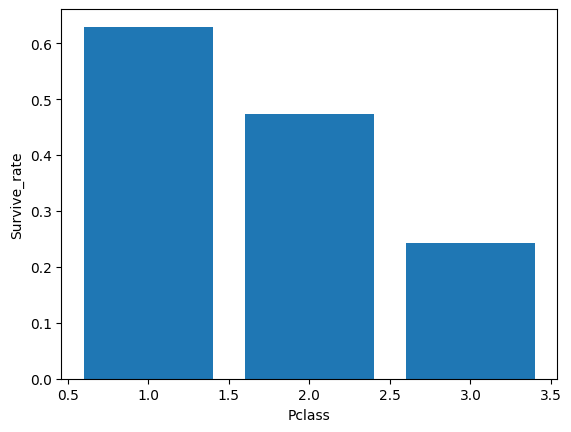

In [264]:
pclass_1 = train_data[train_data.Pclass == 1]
pclass_2 = train_data[train_data.Pclass == 2]
pclass_3 = train_data[train_data.Pclass == 3]
sum_1 = pclass_1.shape[0]
sum_2 = pclass_2.shape[0]
sum_3 = pclass_3.shape[0]
survived_1 = pclass_1[pclass_1.Survived == 1].shape[0]
survived_2 = pclass_2[pclass_2.Survived == 1].shape[0]
survived_3 = pclass_3[pclass_3.Survived == 1].shape[0]
survived_rate_1 = survived_1 / sum_1
survived_rate_2 = survived_2 / sum_2
survived_rate_3 = survived_3 / sum_3
plt.bar([1,2,3],[survived_rate_1,survived_rate_2,survived_rate_3])
plt.xlabel('Pclass')
plt.ylabel('Survive_rate')
plt.show()
# 观察的结果是：Pclass越高，存活率越高

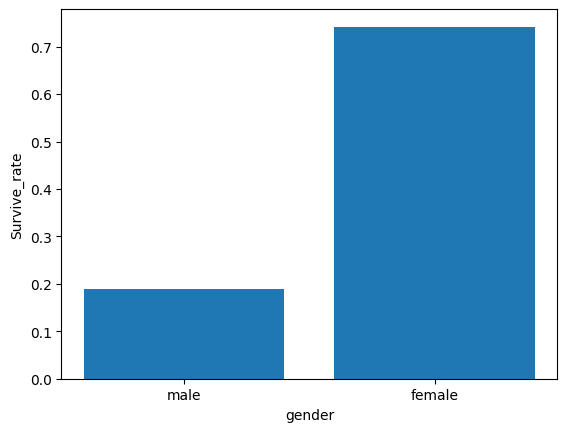

In [265]:
male = train_data[train_data.Sex == 'male']
female = train_data[train_data.Sex == 'female']
sum1 = male.shape[0]
sum2 = female.shape[0]
survived_m = male[male.Survived == 1].shape[0]
survived_f = female[female.Survived == 1].shape[0]
survived_rate_m = survived_m / sum1
survived_rate_f = survived_f / sum2
plt.bar(['male','female'],[survived_rate_m,survived_rate_f])
plt.xlabel('gender')
plt.ylabel('Survive_rate')
plt.show()
# 观察的结果是：女性存活率更高


# 转化sex为0-1
train_data['Sex_num'] = train_data['Sex'].replace({'male':1,'female':0})
train_data.head(5)
test_data['Sex_num'] = test_data['Sex'].replace({'male':1,'female':0})

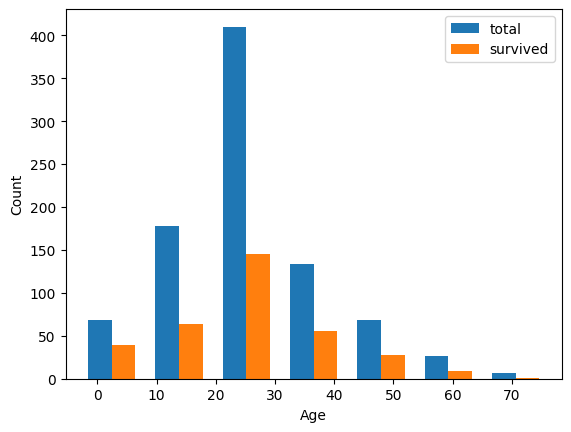

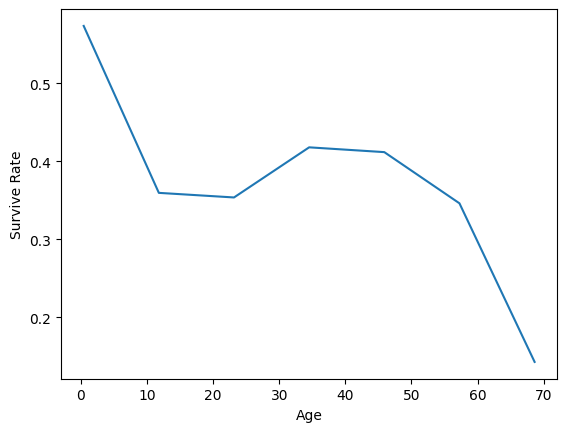

"survived_list = train_data.Survived.tolist()\nage_list = train_data.Age.tolist()\nplt.scatter(age_list, survived_list)\nplt.xlabel('Age')\nplt.ylabel('Survive_ornot')\nplt.show()\n# 观察的结果是：年龄越小，存活人数越多"

In [266]:
age = train_data["Age"].values
bin_width = 10
num_bins = int((age.max() - age.min()) / bin_width)
train_data['age_cul'] = pd.cut(age, num_bins)
survive = train_data[train_data["Survived"] == 1].groupby('age_cul').size().values
hist, bins = np.histogram(age, bins=num_bins)
survive_rate = survive / hist
survive_rate = np.nan_to_num(survive_rate)

width = 0.35 * (bins[1] - bins[0])
plt.bar(bins[:-1], hist, width=width, label='total')
plt.bar(bins[:-1] + width, survive, width=width, label='survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.plot(bins[:-1], survive_rate)
plt.xlabel('Age')
plt.ylabel('Survive Rate')
plt.show()

'''survived_list = train_data.Survived.tolist()
age_list = train_data.Age.tolist()
plt.scatter(age_list, survived_list)
plt.xlabel('Age')
plt.ylabel('Survive_ornot')
plt.show()
# 观察的结果是：年龄越小，存活人数越多'''

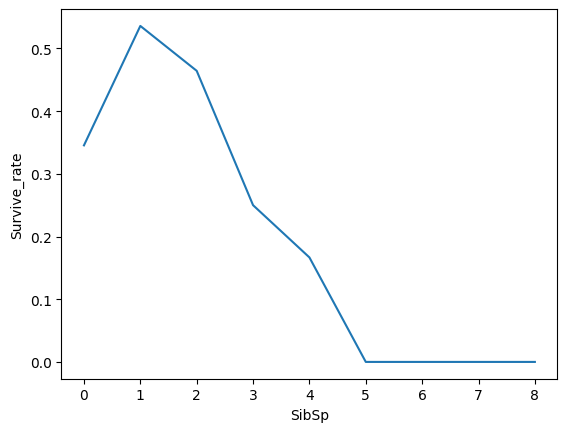

In [267]:
sib1 = train_data[train_data.SibSp == 0]
sib2 = train_data[train_data.SibSp == 1]
sib3 = train_data[train_data.SibSp == 2]
sib4 = train_data[train_data.SibSp == 3]
sib5 = train_data[train_data.SibSp == 4]
sib6 = train_data[train_data.SibSp == 5]
sib7 = train_data[train_data.SibSp == 8]
survived_rate_1 = sib1[sib1.Survived == 1].shape[0] / sib1.shape[0]
survived_rate_2 = sib2[sib2.Survived == 1].shape[0] / sib2.shape[0]
survived_rate_3 = sib3[sib3.Survived == 1].shape[0] / sib3.shape[0]
survived_rate_4 = sib4[sib4.Survived == 1].shape[0] / sib4.shape[0]
survived_rate_5 = sib5[sib5.Survived == 1].shape[0] / sib5.shape[0]
survived_rate_6 = sib6[sib6.Survived == 1].shape[0] / sib6.shape[0]
survived_rate_7 = sib7[sib7.Survived == 1].shape[0] / sib7.shape[0]
plt.plot([0,1,2,3,4,5,8],[survived_rate_1,survived_rate_2,survived_rate_3,survived_rate_4,survived_rate_5,survived_rate_6,survived_rate_7])
plt.xlabel('SibSp')
plt.ylabel('Survive_rate')
plt.show()

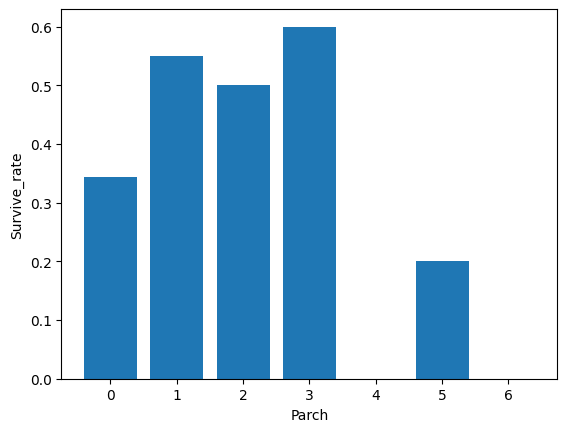

In [268]:
survive_parch1 = train_data[train_data.Parch == 0][train_data[train_data.Parch == 0].Survived == 1].shape[0] / train_data[train_data.Parch == 0].shape[0]
survive_parch2 = train_data[train_data.Parch == 1][train_data[train_data.Parch == 1].Survived == 1].shape[0] / train_data[train_data.Parch == 1].shape[0]
survive_parch3 = train_data[train_data.Parch == 2][train_data[train_data.Parch == 2].Survived == 1].shape[0] / train_data[train_data.Parch == 2].shape[0]
survive_parch4 = train_data[train_data.Parch == 3][train_data[train_data.Parch == 3].Survived == 1].shape[0] / train_data[train_data.Parch == 3].shape[0]
survive_parch5 = train_data[train_data.Parch == 4][train_data[train_data.Parch == 4].Survived == 1].shape[0] / train_data[train_data.Parch == 4].shape[0]
survive_parch6 = train_data[train_data.Parch == 5][train_data[train_data.Parch == 5].Survived == 1].shape[0] / train_data[train_data.Parch == 5].shape[0]
survive_parch7 = train_data[train_data.Parch == 6][train_data[train_data.Parch == 6].Survived == 1].shape[0] / train_data[train_data.Parch == 6].shape[0]
plt.bar([0,1,2,3,4,5,6],[survive_parch1,survive_parch2,survive_parch3,survive_parch4,survive_parch5,survive_parch6,survive_parch7])
plt.xlabel('Parch')
plt.ylabel('Survive_rate')
plt.show()

C:\Users\86135\AppData\Local\Temp\ipykernel_2396\2224884382.py:8: RuntimeWarning: invalid value encountered in true_divide
  survive_rate = survive / hist


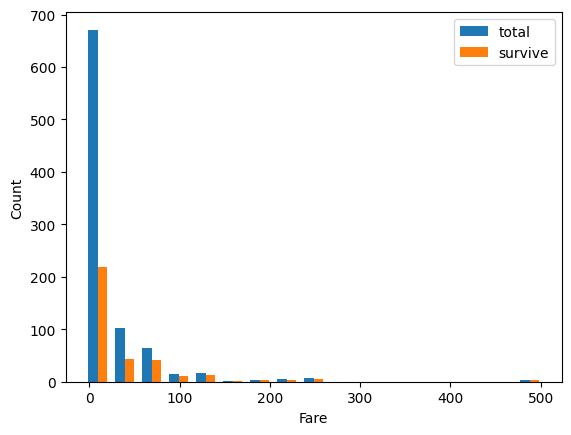

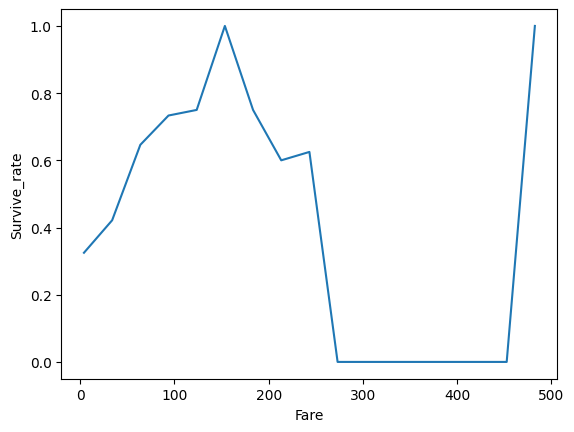

In [269]:
fare = train_data["Fare"].values
bin_width = 30
num_bins = int((fare.max() - fare.min()) / bin_width) + 1
train_data['price_cul'] = pd.cut(fare, bins=num_bins)
survive = train_data[train_data["Survived"] == 1].groupby('price_cul').size()
survive = survive.values
hist, bins = np.histogram(fare, bins=num_bins)
survive_rate = survive / hist
survive_rate = np.nan_to_num(survive_rate)

width = 0.35*bin_width
plt.bar(bins[:-1], hist, width=width, label='total')
plt.bar(bins[:-1] + width, survive, width=width, label='survive')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.legend()
plt.show()


plt.plot(bins[:-1], survive_rate)
plt.xlabel('Fare')
plt.ylabel('Survive_rate')
plt.show()

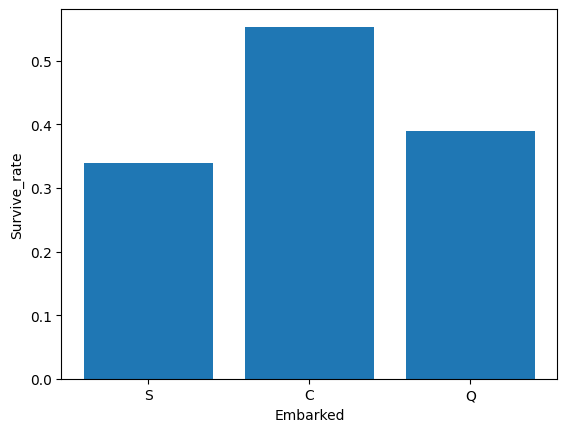

In [270]:
embrak1 = train_data[train_data.Embarked == 'S']
embrak2 = train_data[train_data.Embarked == 'C']
embrak3 = train_data[train_data.Embarked == 'Q']
survive_rate_1 = embrak1[embrak1.Survived == 1].shape[0] / embrak1.shape[0]
survive_rate_2 = embrak2[embrak2.Survived == 1].shape[0] / embrak2.shape[0]
survive_rate_3 = embrak3[embrak3.Survived == 1].shape[0] / embrak3.shape[0]
plt.bar(['S','C','Q'],[survive_rate_1,survive_rate_2,survive_rate_3])
plt.xlabel('Embarked')
plt.ylabel('Survive_rate')
plt.show()


In [271]:
# 查看cabin类型
train_data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [272]:
# 发现cabin完全相同的数据很少，因此简化cabin为其首字母
train_data['Cabin'] = train_data['Cabin'].str[0]
train_data['Cabin'].value_counts()
test_data['Cabin'] = test_data['Cabin'].str[0]

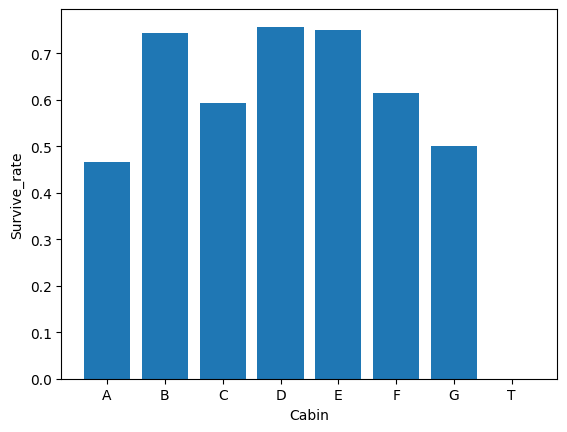

In [273]:
# 查看cabin与survived的关系大不大
A = train_data[train_data.Cabin == 'A']
B = train_data[train_data.Cabin == 'B']
C = train_data[train_data.Cabin == 'C']
D = train_data[train_data.Cabin == 'D']
E = train_data[train_data.Cabin == 'E']
F = train_data[train_data.Cabin == 'F']
G = train_data[train_data.Cabin == 'G']
T = train_data[train_data.Cabin == 'T']
survived_rate_A = A[A.Survived == 1].shape[0] / A.shape[0]
survived_rate_B = B[B.Survived == 1].shape[0] / B.shape[0]
survived_rate_C = C[C.Survived == 1].shape[0] / C.shape[0]
survived_rate_D = D[D.Survived == 1].shape[0] / D.shape[0]
survived_rate_E = E[E.Survived == 1].shape[0] / E.shape[0]
survived_rate_F = F[F.Survived == 1].shape[0] / F.shape[0]
survived_rate_G = G[G.Survived == 1].shape[0] / G.shape[0]
survived_rate_T = T[T.Survived == 1].shape[0] / T.shape[0]
#print(survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T)
plt.bar(['A','B','C','D','E','F','G','T'],[survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T])
plt.xlabel('Cabin')
plt.ylabel('Survive_rate')
plt.show()


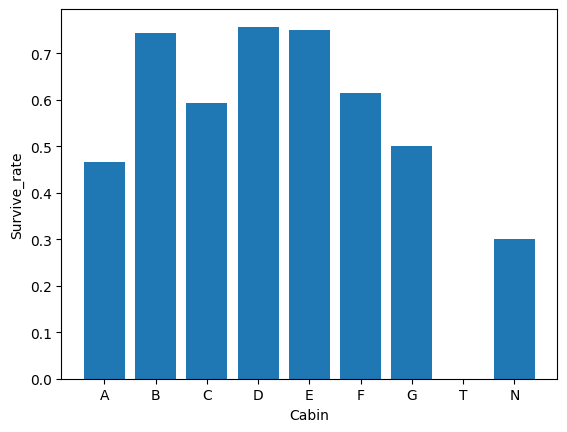

In [274]:
# 发现有cabin标记的数据存活率比总平均存活率高，因此将没有cabin标记的数据标记为‘N’
train_data['Cabin'].fillna('N', inplace=True)

N = train_data[train_data.Cabin == 'N']
survived_rate_N = N[N.Survived == 1].shape[0] / N.shape[0]
plt.bar(['A','B','C','D','E','F','G','T','N'],[survived_rate_A,survived_rate_B,survived_rate_C,survived_rate_D,survived_rate_E,survived_rate_F,survived_rate_G,survived_rate_T,survived_rate_N])
plt.xlabel('Cabin')
plt.ylabel('Survive_rate')
plt.show()
# 观察到N与其他cabin类别的差距和cabin类别间的差距没有很大，因此当前的划分方式比将cabin分为有无两类更合理

# 转化值为数字
train_data['Cabin_num'] = train_data['Cabin'].replace({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'T':7,'G':8,'N':0})
#train_data['Cabin']
train_data['Cabin_num']

test_data['Cabin'].fillna('N', inplace=True)
test_data['Cabin_num'] = test_data['Cabin'].replace({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'T':7,'G':8,'N':0})


#### 独热编码
* 将离散且标签间没有明显顺序关系的特征转化为独热编码
  * 此处仅有embark符合这个条件

In [275]:
# embark拆分成三列
train_data = pd.get_dummies(train_data, columns=['Embarked'])
test_data = pd.get_dummies(test_data, columns=['Embarked'])
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_num,age_cul,price_cul,Cabin_num,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,N,1,"(11.789, 23.157]","(3.504, 33.913]",0,0,0,1


#### 构建更有意义的特征
* sibsp表示兄弟姐妹和配偶人数，parch表示父母和子女人数，两个特征求和再加自己表示家庭成员人数
    * 1表示独自一人，2-3表示小家庭，4-7表示中等家庭，8以上表示大家庭
  
    用不同方式表示构建家庭成员人数的特征，观察哪种方式更合理

In [276]:
# 创建新特征：家庭成员数
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
train_data['FamilySize'].value_counts()


1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

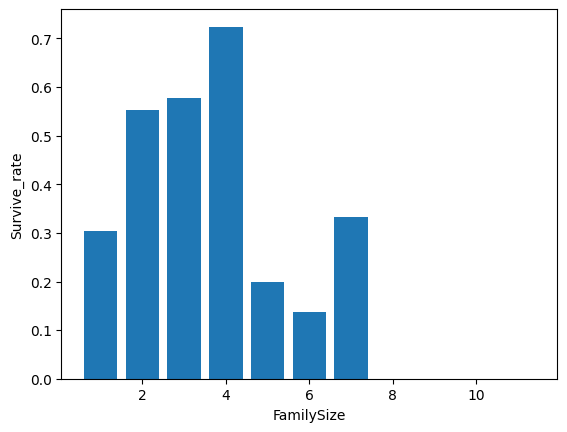

In [277]:
survived_rate_1 = train_data[train_data.FamilySize == 1][train_data[train_data.FamilySize == 1].Survived == 1].shape[0] / train_data[train_data.FamilySize == 1].shape[0]
survived_rate_2 = train_data[train_data.FamilySize == 2][train_data[train_data.FamilySize == 2].Survived == 1].shape[0] / train_data[train_data.FamilySize == 2].shape[0]
survived_rate_3 = train_data[train_data.FamilySize == 3][train_data[train_data.FamilySize == 3].Survived == 1].shape[0] / train_data[train_data.FamilySize == 3].shape[0]
survived_rate_4 = train_data[train_data.FamilySize == 4][train_data[train_data.FamilySize == 4].Survived == 1].shape[0] / train_data[train_data.FamilySize == 4].shape[0]
survived_rate_5 = train_data[train_data.FamilySize == 5][train_data[train_data.FamilySize == 5].Survived == 1].shape[0] / train_data[train_data.FamilySize == 5].shape[0]
survived_rate_6 = train_data[train_data.FamilySize == 6][train_data[train_data.FamilySize == 6].Survived == 1].shape[0] / train_data[train_data.FamilySize == 6].shape[0]
survived_rate_7 = train_data[train_data.FamilySize == 7][train_data[train_data.FamilySize == 7].Survived == 1].shape[0] / train_data[train_data.FamilySize == 7].shape[0]
survived_rate_8 = train_data[train_data.FamilySize == 8][train_data[train_data.FamilySize == 8].Survived == 1].shape[0] / train_data[train_data.FamilySize == 8].shape[0]
survived_rate_11 = train_data[train_data.FamilySize == 11][train_data[train_data.FamilySize == 11].Survived == 1].shape[0] / train_data[train_data.FamilySize == 11].shape[0]
plt.bar([1,2,3,4,5,6,7,8,11],[survived_rate_1,survived_rate_2,survived_rate_3,survived_rate_4,survived_rate_5,survived_rate_6,survived_rate_7,survived_rate_8,survived_rate_11])
plt.xlabel('FamilySize')
plt.ylabel('Survive_rate')
plt.show()


In [278]:
# 观察到家庭成员数为2~4时存活率较高，因此将家庭成员数分为4类：独自，小家庭，中等家庭，大家庭
train_data['FamilySizeDiscrete'] = np.where((train_data['FamilySize'] == 1), 'Alone', '')
train_data['FamilySizeDiscrete'] = np.where((train_data['FamilySize'] >= 2) & (train_data['FamilySize'] <= 4), 'Small', train_data['FamilySizeDiscrete'])
train_data['FamilySizeDiscrete'] = np.where((train_data['FamilySize'] >= 5) & (train_data['FamilySize'] <= 7), 'Medium', train_data['FamilySizeDiscrete'])
train_data['FamilySizeDiscrete'] = np.where((train_data['FamilySize'] >= 8), 'Large', train_data['FamilySizeDiscrete'])
test_data['FamilySizeDiscrete'] = np.where((test_data['FamilySize'] == 1), 'Alone', '')
test_data['FamilySizeDiscrete'] = np.where((test_data['FamilySize'] >= 2) & (test_data['FamilySize'] <= 4), 'Small', test_data['FamilySizeDiscrete'])
test_data['FamilySizeDiscrete'] = np.where((test_data['FamilySize'] >= 5) & (test_data['FamilySize'] <= 7), 'Medium', test_data['FamilySizeDiscrete'])
test_data['FamilySizeDiscrete'] = np.where((test_data['FamilySize'] >= 8), 'Large', test_data['FamilySizeDiscrete'])

train_data['FamilySizeDiscrete'].value_counts()

Alone     537
Small     292
Medium     49
Large      13
Name: FamilySizeDiscrete, dtype: int64

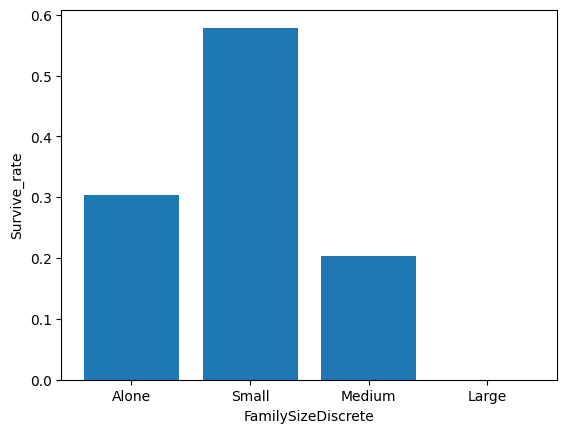

0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: FamilySizeD_num, Length: 891, dtype: int64

In [279]:
survive_a = train_data[train_data.FamilySizeDiscrete == 'Alone'][train_data[train_data.FamilySizeDiscrete == 'Alone'].Survived == 1].shape[0] / train_data[train_data.FamilySizeDiscrete == 'Alone'].shape[0]
survive_s = train_data[train_data.FamilySizeDiscrete == 'Small'][train_data[train_data.FamilySizeDiscrete == 'Small'].Survived == 1].shape[0] / train_data[train_data.FamilySizeDiscrete == 'Small'].shape[0]
survive_m = train_data[train_data.FamilySizeDiscrete == 'Medium'][train_data[train_data.FamilySizeDiscrete == 'Medium'].Survived == 1].shape[0] / train_data[train_data.FamilySizeDiscrete == 'Medium'].shape[0]
survive_l = train_data[train_data.FamilySizeDiscrete == 'Large'][train_data[train_data.FamilySizeDiscrete == 'Large'].Survived == 1].shape[0] / train_data[train_data.FamilySizeDiscrete == 'Large'].shape[0]
plt.bar(['Alone','Small','Medium','Large'],[survive_a,survive_s,survive_m,survive_l])
plt.xlabel('FamilySizeDiscrete')
plt.ylabel('Survive_rate')
plt.show()
train_data.head(1)

# 转化为数字
train_data['FamilySizeD_num'] = train_data['FamilySizeDiscrete'].replace({'Alone':1,'Small':2,'Medium':3,'Large':4})
test_data['FamilySizeD_num'] = test_data['FamilySizeDiscrete'].replace({'Alone':1,'Small':2,'Medium':3,'Large':4})
train_data['FamilySizeD_num']
#train_data['FamilySizeDiscrete']

#### 处理文字特征name
* 由于单纯名字对判断生存率意义不大，因此选择对称谓分类

In [280]:
# 首先对名字分词
for index, row in train_data.iterrows():
    name = row['Name'].split(',')[1].split('.')[0].strip()
    train_data.loc[index, 'Title'] = name
for index, row in test_data.iterrows():
    name = row['Name'].split(',')[1].split('.')[0].strip()
    test_data.loc[index, 'Title'] = name
train_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [281]:
# 经查询知:
# Mr:已婚男士
# Mrs:已婚女士
# Miss:未婚女士
# Master:小男孩
# Dr:医生
# Rev:牧师
# Col:陆军上校
# Major:陆军少校
# Mlle:法语“小姐”（Miss的法语缩写）
# Ms:女士
# Mme:法语“夫人”（Mrs的法语缩写）
# Sir:爵士
# Lady:女士
# Countess:女伯爵
# Don:西班牙语中的贵族称呼，相当于英语中的Sir
# Jonkheer:荷兰语中的贵族称呼，相当于英语中的Sir
# Capt:船长

# 由此将称谓分为6类
# Mr,
# Mrs,Ms,Mme,Lady ==> Mrs
# Miss,Mlle ==> Miss
# Master,
# Dr,Rev,Col,Major,Capt ==> Officer
# Sir,Countess,Don,Jonkheer ==> Royalty

train_data['Title'] = train_data['Title'].replace(['Ms', 'Mme', 'Lady'], 'Mrs')
train_data['Title'] = train_data['Title'].replace(['Mlle'], 'Miss')
train_data['Title'] = train_data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')
train_data['Title'] = train_data['Title'].replace(['Sir', 'the Countess', 'Don', 'Jonkheer'], 'Royalty')
test_data['Title'] = test_data['Title'].replace(['Ms', 'Mme', 'Lady'], 'Mrs')
test_data['Title'] = test_data['Title'].replace(['Mlle'], 'Miss')
test_data['Title'] = test_data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')
test_data['Title'] = test_data['Title'].replace(['Sir', 'the Countess', 'Don', 'Jonkheer'], 'Royalty')

test_data['Title'].value_counts()



Mr         240
Miss        78
Mrs         73
Master      21
Officer      5
Dona         1
Name: Title, dtype: int64

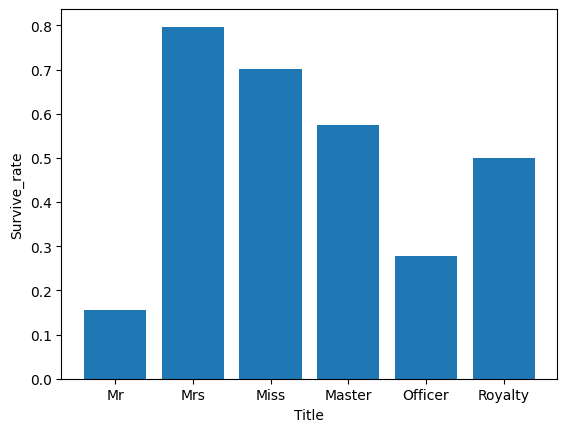

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Sex_num', 'age_cul', 'price_cul',
       'Cabin_num', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize',
       'FamilySizeDiscrete', 'FamilySizeD_num', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty'],
      dtype='object')

In [282]:
survive_mr = train_data[train_data.Title == 'Mr'][train_data[train_data.Title == 'Mr'].Survived == 1].shape[0] / train_data[train_data.Title == 'Mr'].shape[0]
survive_mrs = train_data[train_data.Title == 'Mrs'][train_data[train_data.Title == 'Mrs'].Survived == 1].shape[0] / train_data[train_data.Title == 'Mrs'].shape[0]
survive_miss = train_data[train_data.Title == 'Miss'][train_data[train_data.Title == 'Miss'].Survived == 1].shape[0] / train_data[train_data.Title == 'Miss'].shape[0]
survive_master = train_data[train_data.Title == 'Master'][train_data[train_data.Title == 'Master'].Survived == 1].shape[0] / train_data[train_data.Title == 'Master'].shape[0]
survive_officer = train_data[train_data.Title == 'Officer'][train_data[train_data.Title == 'Officer'].Survived == 1].shape[0] / train_data[train_data.Title == 'Officer'].shape[0]
survive_royalty = train_data[train_data.Title == 'Royalty'][train_data[train_data.Title == 'Royalty'].Survived == 1].shape[0] / train_data[train_data.Title == 'Royalty'].shape[0]
plt.bar(['Mr','Mrs','Miss','Master','Officer','Royalty'],[survive_mr,survive_mrs,survive_miss,survive_master,survive_officer,survive_royalty])
plt.xlabel('Title')
plt.ylabel('Survive_rate')
plt.show()
# 转化成one-hot编码
train_data = pd.get_dummies(train_data, columns=['Title'])
test_data = pd.get_dummies(test_data, columns=['Title'])
# 为test补充Title_Royalty列
test_data['Title_Royalty'] = 0
train_data.columns

### step2 选择特征
* 'Pclass',  'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cabin_num', 
* 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'FamilySizeD_num'
* 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty'

In [283]:
feature_select = train_data.loc[:,['Pclass',  'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cabin_num', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'FamilySizeD_num', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty']]
feature_select_test = test_data.loc[:,['Pclass',  'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cabin_num', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'FamilySizeD_num', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty']]
#feature_select.drop(0)
#feature_select
matrix_raw = []
for row in feature_select.iterrows():
    matrix_raw.append(row[1].values)
    #print(row[1].values)
matrix = np.asarray(matrix_raw)
matrix

array([[ 3., 22.,  1., ...,  0.,  0.,  0.],
       [ 1., 38.,  1., ...,  1.,  0.,  0.],
       [ 3., 26.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 3., 28.,  1., ...,  0.,  0.,  0.],
       [ 1., 26.,  0., ...,  0.,  0.,  0.],
       [ 3., 32.,  0., ...,  0.,  0.,  0.]])

In [284]:
# 方差法判断特征是否发散
selector = VarianceThreshold(threshold=0.5)
selected_matrix = selector.fit_transform(matrix)
selected_idx = selector.get_support(indices=True)
print(f'被保留的特征索引：{selected_idx}')

被保留的特征索引：[ 0  1  2  3  4  6 10]


In [285]:
# 包装法判断与目标是否相关
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
selector = RFE(estimator=LogisticRegression(), n_features_to_select=10)
selected_matrix = selector.fit_transform(matrix, train_data['Survived'])
selected_idx = selector.get_support(indices=True)
print(f'被保留的特征索引：{selected_idx}')

被保留的特征索引：[ 0  5  7 10 12 13 14 15 16 17]


c:\Users\86135\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\86135\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [286]:
# 嵌入法判断与目标是否相关
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
selector = SelectFromModel(estimator=GradientBoostingClassifier())
selected_matrix = selector.fit_transform(matrix, train_data['Survived'])
selected_idx = selector.get_support(indices=True)
print(f'被保留的特征索引：{selected_idx}')

被保留的特征索引：[ 0  1  4 14]


### step3 特征降维
* 观察到称谓和性别年龄、家庭大小和家庭人数兄弟姐妹数量等特征之间存在一定程度的雷同，因此选择LDA进行特征降维

In [287]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(matrix)
pca_matrix = pca.transform(matrix)
pca_matrix_idx = pca.components_.argsort()[::-1][:pca.n_components]
print(f'被保留的特征索引：{pca_matrix_idx}')
print(pca_matrix)

被保留的特征索引：[[10  4  2  0 11  3 13 12  8  7 17  9 16  5 15 14  6  1]
 [ 0 14  5  9  8 12 16 17 15 13  7  2  3 11 10  6  1  4]]
[[-26.09647033  -6.65954902]
 [ 38.4096831    7.60048656]
 [-25.31872111  -2.63621537]
 ...
 [ -9.71255022  -1.23678721]
 [ -3.20551719  -3.14665461]
 [-25.32872795   3.37682016]]


In [288]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
selector = LDA(n_components=1)
selected_matrix = selector.fit_transform(feature_select, train_data['Survived'])
print(feature_select.shape[1])
print(selected_matrix.shape[1])

18
1


## Ⅳ 模型构建及训练

In [289]:
y = train_data["Survived"]

#features = ["Pclass","Sex","SibSp","Parch"]
X = pd.get_dummies(feature_select)
X_test = pd.get_dummies(feature_select_test)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X,y)
print(X_test)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('data/my_submission.csv', index=False)

     Pclass   Age  SibSp  Parch      Fare  Sex_num  Cabin_num  Embarked_C  \
0         3  34.5      0      0    7.8292        1          0           0   
1         3  47.0      1      0    7.0000        0          0           0   
2         2  62.0      0      0    9.6875        1          0           0   
3         3  27.0      0      0    8.6625        1          0           0   
4         3  22.0      1      1   12.2875        0          0           0   
..      ...   ...    ...    ...       ...      ...        ...         ...   
413       3  27.0      0      0    8.0500        1          0           0   
414       1  39.0      0      0  108.9000        0          3           1   
415       3  38.5      0      0    7.2500        1          0           0   
416       3  27.0      0      0    8.0500        1          0           0   
417       3  27.0      1      1   22.3583        1          0           1   

     Embarked_Q  Embarked_S  FamilySize  FamilySizeD_num  Title_Master  \
0

In [290]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(feature_select, train_data['Survived'])
print(train_x, train_y, '\n')
print(test_x, test_y)

#print(type(train_x))
#print(type(train_y))

     Pclass   Age  SibSp  Parch      Fare  Sex_num  Cabin_num  Embarked_C  \
255       3  29.0      0      2   15.2458        0          0           1   
172       3   1.0      1      1   11.1333        0          0           0   
260       3  28.0      0      0    7.7500        1          0           0   
697       3  28.0      0      0    7.7333        0          0           0   
214       3  28.0      1      0    7.7500        1          0           0   
..      ...   ...    ...    ...       ...      ...        ...         ...   
587       1  60.0      1      1   79.2000        1          2           1   
543       2  32.0      1      0   26.0000        1          0           0   
442       3  25.0      1      0    7.7750        1          0           0   
303       2  28.0      0      0   12.3500        0          5           0   
689       1  15.0      0      1  211.3375        0          2           0   

     Embarked_Q  Embarked_S  FamilySize  FamilySizeD_num  Title_Master  \
2

In [291]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
log_reg = linear_model.LogisticRegression(max_iter = 1000)

lin_reg.fit(train_x, train_y)
print(f'intercept: {lin_reg.intercept_: .2f}')
print('coef: ',lin_reg.coef_)

test_predict = lin_reg.predict(test_x)
lin_reg.score(test_x, test_y)


intercept:  1.44
coef:  [-1.35779630e-01 -3.11881146e-03 -2.15649439e-02 -5.37675356e-03
  2.45147124e-04 -6.72799575e-01  2.21155500e-02  3.44765641e-02
  1.05594439e-02 -4.50360080e-02 -2.69416975e-02 -3.27221368e-02
  5.20381904e-01 -2.35485162e-01 -8.99070688e-02 -1.31512455e-01
 -1.44977676e-01  8.15004568e-02]


0.38918030374917045

In [292]:
log_reg.fit(train_x, train_y)
#print('intercept:', log_reg.intercept_)
#print('coef: ',log_reg.coef_)

test_predict = log_reg.predict(test_x)
log_reg.score(test_x, test_y)

0.820627802690583

In [293]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

decision_tree_classifier = DecisionTreeClassifier(criterion="entropy")  #使用信息熵增益
scv = LinearSVC()

dcTree = decision_tree_classifier.fit(train_x, train_y)
test_predict = decision_tree_classifier.predict(test_x)
decision_tree_classifier.score(test_x, test_y)

0.7488789237668162

In [294]:
Lscv = scv.fit(train_x, train_y)
test_predict = scv.predict(test_x)

scv.score(test_x, test_y)

c:\Users\86135\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8161434977578476

In [295]:
#print(train_x.dtypes)
#print(train_y.dtypes)
# 将bool类型列转换为int64类型
train_x['Embarked_C'] = train_x['Embarked_C'].astype(int)
train_x['Embarked_Q'] = train_x['Embarked_Q'].astype(int)
train_x['Embarked_S'] = train_x['Embarked_S'].astype(int)
train_x['Title_Master'] = train_x['Title_Master'].astype(int)
train_x['Title_Miss'] = train_x['Title_Miss'].astype(int)
train_x['Title_Mr'] = train_x['Title_Mr'].astype(int)
train_x['Title_Mrs'] = train_x['Title_Mrs'].astype(int)
train_x['Title_Officer'] = train_x['Title_Officer'].astype(int)
train_x['Title_Royalty'] = train_x['Title_Royalty'].astype(int)

test_x['Embarked_C'] = test_x['Embarked_C'].astype(int)
test_x['Embarked_Q'] = test_x['Embarked_Q'].astype(int)
test_x['Embarked_S'] = test_x['Embarked_S'].astype(int)
test_x['Title_Master'] = test_x['Title_Master'].astype(int)
test_x['Title_Miss'] = test_x['Title_Miss'].astype(int)
test_x['Title_Mr'] = test_x['Title_Mr'].astype(int)
test_x['Title_Mrs'] = test_x['Title_Mrs'].astype(int)
test_x['Title_Officer'] = test_x['Title_Officer'].astype(int)
test_x['Title_Royalty'] = test_x['Title_Royalty'].astype(int)


In [296]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        x = x * (torch.tanh(torch.nn.functional.softplus(x)))
        return x
    
torch.manual_seed(0)

class ThreeLinearModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(18,18)
        self.mish1 = Mish()
        self.linear2 = nn.Linear(18,8)
        self.mish2 = Mish()
        self.linear3 = nn.Linear(8,2)
        self.softmax = nn.Softmax(dim = 1)
        self.criterion = nn.CrossEntropyLoss() #定义交叉熵

    def forward(self, x):   #定义一个全连接网络
        lin1_out = self.linear1(x)
        #print(type(lin1_out))
        out1 = self.mish1(lin1_out)
        out2 = self.mish2(self.linear2(out1))
        return self.softmax(self.linear3(out2))
    
    def getloss(self,x,y):  #实现类的损失值计算接口
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)
        return loss

In [297]:
net = ThreeLinearModule()
num_epochs = 200
optimizer = torch.optim.Adam(net.parameters(),lr=0.04)

#将输入样本转化为标量
input_tensor = torch.from_numpy(train_x.to_numpy()).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_y.to_numpy())
losses = [] #定义损失值列表
for epoch in range(num_epochs):
    loss = net.getloss(input_tensor, label_tensor)
    losses.append(loss.item())
    optimizer.zero_grad() #清空之前的梯度
    loss.backward() #反向传播损失值
    optimizer.step() #更新参数
    if epoch % 20 == 0:
        print('Epoch {}/{} => Loss: {:.2f}'.format(epoch + 1, num_epochs, loss.item()))

# 输出训练结果
# tensor.detach():从计算图中脱离出来，返回一个新的tensor，新的tensor和原tensor共享数据内存，（这也就意味着修改一个tensor的值，另外一个也会改变），
#                  但是不涉及梯度计算。在从tensor转换成为numpy的时候，如果转换前面的tensor在计算图里面（requires_grad = True），那么这个时候只能先进行detach操作才能转换成为numpy
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_y.values) / len(train_y.values))
 
# 测试模型
test_input_tensor = torch.from_numpy(test_x.to_numpy()).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_y.to_numpy()) / len(test_y.to_numpy()))
        

c:\Users\86135\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/200 => Loss: 0.84
Epoch 21/200 => Loss: 0.51
Epoch 41/200 => Loss: 0.47
Epoch 61/200 => Loss: 0.46
Epoch 81/200 => Loss: 0.45
Epoch 101/200 => Loss: 0.47
Epoch 121/200 => Loss: 0.45
Epoch 141/200 => Loss: 0.45
Epoch 161/200 => Loss: 0.45
Epoch 181/200 => Loss: 0.47
Train Accuracy: 0.8622754491017964
Test Accuracy: 0.8251121076233184
